# Area radius scaling

In [1]:
!make -C .. agglomeration_extracts

make: Entering directory '/home/martibosch/data-science/swiss-urbanization'
make: Nothing to be done for 'agglomeration_extracts'.
make: Leaving directory '/home/martibosch/data-science/swiss-urbanization'


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylandstats as pls
import pwlf
import swisslandstats as sls
from mpl_toolkits.axes_grid1 import inset_locator
from scipy import stats
from shapely.geometry import Point

from swiss_urbanization.data import settings

In [3]:
urban_class = settings.EXTRACTS_URBAN
nodata = settings.EXTRACTS_NODATA

agglom_slugs = ['bern', 'lausanne', 'zurich']

buffer_dists = list(range(1000, 20000, 500))
# TODO: change hardcoded points and use overpass API filtering by tag
# `admin_centre:4=yes`
base_mask_dict = {
    'bern': Point(7.4514512, 46.9482713),
    'lausanne': Point(6.6327025, 46.5218269),
    'zurich': Point(8.5414061, 47.3769434)
}
base_mask_crs = {'init':'epsg:4326'}

In [4]:
agglom_dict = {}
for agglom_slug in agglom_slugs:
    _dict = {}
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    base_mask = base_mask_dict[agglom_slug]
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        year = ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0]
        _dict[year] = pls.BufferAnalysis(
            pls.Landscape(ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                          res=ldf.res,
                          nodata=nodata),
            base_mask,
            buffer_dists=buffer_dists,
            base_mask_crs=base_mask_crs,
            landscape_crs=ldf.crs,
            landscape_transform=ldf.get_transform())
    agglom_dict[agglom_slug] = _dict

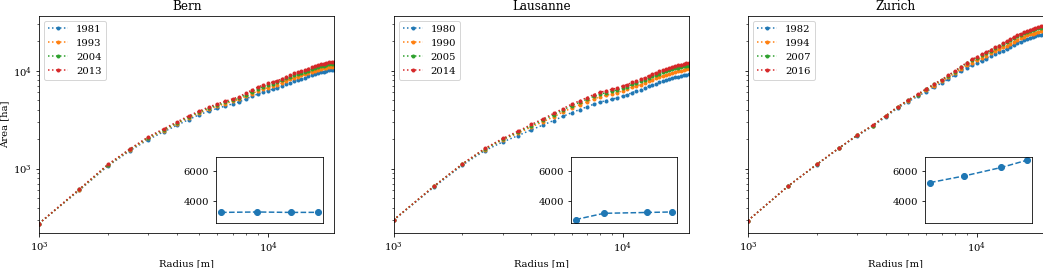

In [5]:
num_aggloms = len(agglom_slugs)

figwidth, figheight = plt.rcParams['figure.figsize']
fig, axes = plt.subplots(1,
                         num_aggloms,
                         figsize=(num_aggloms * figwidth, figheight),
                         sharey=True)

axin = None  # for sharey
for agglom_slug, ax in zip(agglom_slugs, axes):
    _dict = agglom_dict[agglom_slug]
    # sc_rsqs = []
    # pw_rsqs = []
    bkps = []
    for year in _dict:
        total_area_ser = _dict[year].compute_class_metrics_df(
            metrics=['total_area'],
            classes=[urban_class]).loc[urban_class]['total_area']
        total_area_ser.plot(loglog=True,
                            ax=ax,
                            label=year,
                            linestyle=':',
                            marker='.')

        x, y = np.log(total_area_ser.index.values), np.log(
            total_area_ser.values)
        # slope, intercept, r_sq, p_val, stder = stats.linregress(x, y)
        # sc_rsqs.append(r_sq)

        pw = pwlf.PiecewiseLinFit(x, y)
        pw_res = pw.fit(2)
        # pw_rsqs.append(pw.r_squared())

        bkps.append(np.exp(pw_res[1]))

    ax.legend()
    ax.set_xlabel('Radius [m]')
    ax.set_title(agglom_slug.capitalize())

    agglom_years = list(_dict.keys())
    axin = ax.inset_axes([.6, .05, .36, .3], sharey=axin)
    # axin.plot(agglom_years, sc_rsqs, '--d')
    # axin.plot(agglom_years, pw_rsqs, '--x')
    axin.plot(agglom_years, bkps, '--o')
    # axin.set_xticks(agglom_years)
    axin.set_xticks([])

fig.axes[0].set_ylabel('Area [ha]')
fig.savefig('../reports/figures/area_radius_scaling.pdf')